In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.io import readsav
from matplotlib import cm
import cartopy.crs as ccrs
from scipy.ndimage import gaussian_filter
import pickle
homedir = os.path.expanduser("~")
datadir = f"{homedir}/uoedrive/data/gcm_hires/w1049b-sept2025"

In [3]:
# read high-res gcm data
spectrum = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_broaden_time1.txt")
spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time1.txt")
wl = np.loadtxt(f"{datadir}/high-resolution/wavelength_micron.txt")

In [11]:
wl.shape

(460654,)

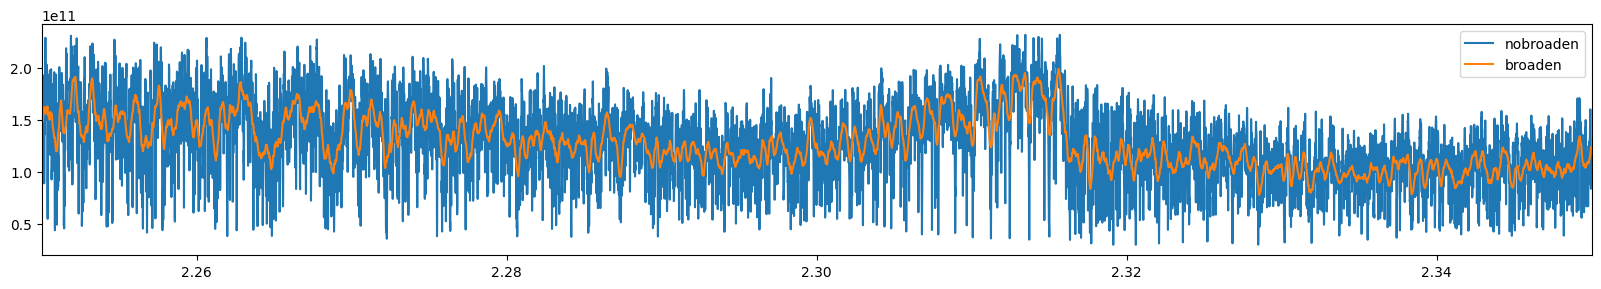

In [4]:
wlind = np.where((wl>2.25) & (wl<2.35))
plt.figure(figsize=(20,3))
plt.plot(wl[wlind], spec_nobroad[wlind], label='nobroaden')
plt.plot(wl[wlind], spectrum[wlind], label='broaden')
plt.xlim(2.25, 2.35)
plt.legend()

In [5]:
# make data pickles
# wav is [nchip, npix]
# obs is [nt, nchip, npix]
chipswl = [(2.225,2.241),(2.242,2.256),(2.300,2.317),(2.318,2.334)] # K2148
npix = 1550
wav = np.empty((len(chipswl), npix))
observed = np.empty((20, len(chipswl), npix))
error = np.empty((20, len(chipswl), npix))
template = np.empty((20, len(chipswl), npix))

for t in range(20):
    spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time{t+1}.txt")
    spectrum = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_broaden_time{t+1}.txt")
    for chip in range(len(chipswl)):
        wlmin, wlmax = chipswl[chip]
        wlind = np.where((wl>wlmin) & (wl<wlmax))
        wav[chip] = wl[wlind][:npix]
        data = spectrum[wlind][:npix]
        model = spec_nobroad[wlind][:npix]
        size = 5
        sigma = np.array([np.std(data[max(0,i-size):min(len(data),i+size+1)]) for i in range(len(data))]) # local running std as error
        observed[t,chip] = data
        error[t,chip] = sigma
        template[t, chip] = model

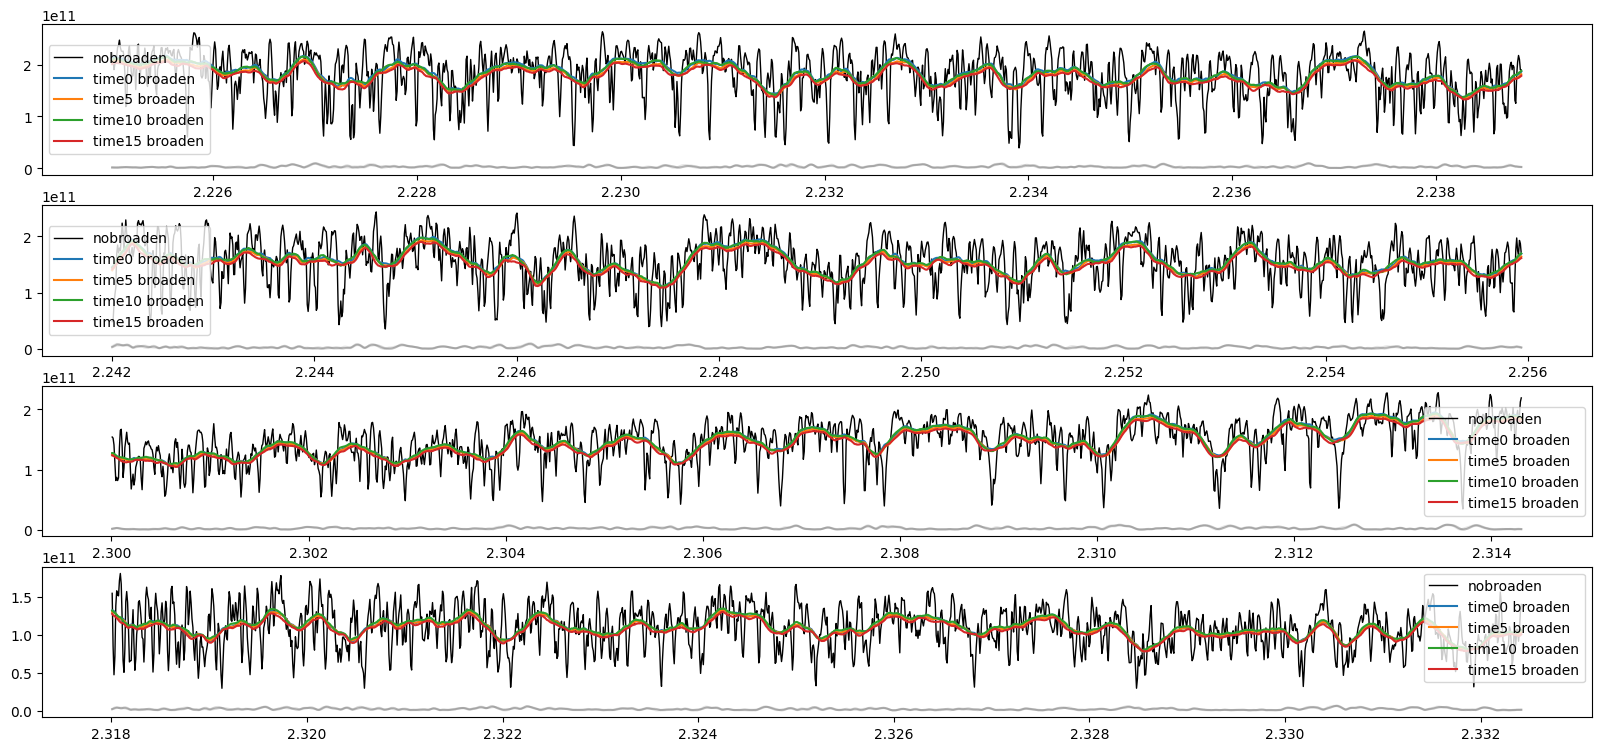

In [6]:
plt.figure(figsize=(20,9))
for chip in range(len(chipswl)):
    plt.subplot(len(chipswl),1,chip+1)
    plt.plot(wav[chip], np.nanmedian(template[:,chip,:],axis=0), color='k', linewidth=1, label=f'nobroaden')
    for t in [0,5,10,15]:
        plt.plot(wav[chip], observed[t,chip], label=f'time{t} broaden')
        plt.plot(wav[chip], error[t,chip], color='k', alpha=0.1)
    plt.legend()

In [8]:
spec_nobroad_all = []
for t in range(20):
    spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time{t+1}.txt")
    spec_nobroad_all.append(spec_nobroad)
spec_nobroad_all = np.array(spec_nobroad_all)
spec_nobroad_all.shape

(20, 460654)

In [10]:
wav.shape

(4, 1550)

In [15]:
np.diff(wl).mean()

9.1468790608115e-06

In [24]:
from scipy.interpolate import interp1d
spec_nobroad_mean = np.nanmedian(spec_nobroad_all,axis=0)
wl_lin = np.arange(1.51, 2.50+0.05*1e-4, 0.05*1e-4, dtype=np.float32)  # Include endpoint
interp_func = interp1d(wl, spec_nobroad_mean, kind='linear', bounds_error=False, fill_value=0.0)
spec_nobroad_lin = interp_func(wl_lin)
spec_nobroad_lin.shape

(198001,)

In [25]:
# save 'model' to fits

hdu = fits.PrimaryHDU(spec_nobroad_lin.astype(np.float32))

# WCS header keywords
hdu.header['CRPIX1'] = 1                     # Reference pixel
hdu.header['CRVAL1'] = 15100          # Wavelength at reference pixel
hdu.header['CDELT1'] = 0.05           # Step size
hdu.header['CTYPE1'] = 'LINEAR'

# Write to FITS
hdu.writeto(f'{datadir}/w1049b_gcmhires_nobroad_lin.fits', overwrite=True)

In [7]:
# prepare pickle file
saveout = dict(
    chiplams=np.tile(wav, (20, 1, 1)), 
    chipmodnobroad=template, 
    observed=observed, 
    error=error)
with open(f'../data/fitted/ELT_W1049B_K_gcm.pickle', 'wb') as f:
    pickle.dump(saveout, f)